## 데이터분석

In [ ]:
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import math
import seaborn as sns
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from matplotlib import font_manager, rc
# 한글 폰트 설정
font_path = "C:/Windows/Fonts/malgun.ttf"  # 한글 폰트 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

데이터 load, 시트간 merge

In [2]:
data = pd.read_excel("../data/TSB_data.xlsx", sheet_name='야드크레이인_작업이력')
scd_data = pd.read_excel("../data/TSB_data.xlsx", sheet_name='반출입_예정컨테이너')
cbd_data = pd.read_excel("../data/TSB_data.xlsx", sheet_name='장치장_전')
cad_data = pd.read_excel("../data/TSB_data.xlsx", sheet_name='장치장_후')
quay_work_data = pd.read_excel("../data/TSB_data.xlsx", sheet_name='본선크레인_작업이력')

# int 타입임
quay_work_data['작업완료시간'] = quay_work_data['작업완료시간'].astype(str).replace('^2020', '2023', regex=True)
merge_list = []
# data, container_before_data, container_after_data merge
ycb_common_values = data['컨테이너번호'].isin(quay_work_data['컨테이너번호']).sum() # 6103개
# data_quay_work_common_df = pd.merge(data, quay_work_data, on='컨테이너번호')
# data_scd_work_common_df = pd.merge(data, scd_data, on='컨테이너번호')
data_cad_data_common_df = pd.merge(data, cad_data, on='컨테이너번호')
# merge_list.append(data_quay_work_common_df)
# merge_list.append(data_scd_work_common_df)
# merge_list.append(data_cad_data_common_df)
common_df = data_cad_data_common_df
print(common_df.shape)

(6103, 40)


데이터 전처리(날짜 - datetime, 문자열 - 숫자)

In [3]:
# data_after merge
common_df['작업코드'] = common_df['작업코드'].replace({'VU': 1, 'VL': 2, 'GR': 3, 'GD': 4, 'TM':5,'TS':6})
common_df['장비번호'] = common_df['장비번호'].replace({'Y02': 1})
common_df['풀(F)공(M)'] = common_df['풀(F)공(M)'].replace({'M':1, 'F':2})
common_df['수출/수입'] = common_df['수출/수입'].replace({'X':1,'I':2,'S':3,'M':4})
    
#시간 타입 통합
common_df['작업생성시간'] = pd.to_datetime(common_df['작업생성시간'], format='%Y%m%d%H%M%S')
common_df['작업완료시간'] = pd.to_datetime(common_df['작업완료시간'], format='%Y%m%d%H%M%S')

# 외부트럭에 1 넣기
common_df['야드트럭(번호)'] = common_df['야드트럭(번호)'].fillna(1)
# print('common_df',common_df)
# print('작업생성시간',common_df['작업생성시간'].dtype)
# print('작업완료시간',common_df['작업완료시간'].dtype)
common_df['작업+대기시간'] = common_df['작업완료시간'] -common_df['작업생성시간']
# print(common_df[['작업코드','항차_x','야드트럭(번호)','컨테이너(사이즈 코드)','장비번호', '작업생성시간','작업완료시간']])
print(common_df['작업+대기시간'].isna().sum())
print('common_df',common_df.info())
# common_df = common_df[-1000:]
# print(common_df.shape)

2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6103 entries, 0 to 6102
Data columns (total 41 columns):
 #   Column         Non-Null Count  Dtype          
---  ------         --------------  -----          
 0   컨테이너번호         6103 non-null   object         
 1   작업코드           6103 non-null   int64          
 2   선박코드_x         6103 non-null   object         
 3   년도_x           6103 non-null   int64          
 4   항차_x           6103 non-null   int64          
 5   블록_x           6092 non-null   object         
 6   베이_x           6092 non-null   float64        
 7   로우_x           2313 non-null   float64        
 8   티어_x           2313 non-null   float64        
 9   블록2            6103 non-null   object         
 10  베이2            6103 non-null   int64          
 11  로우2            5779 non-null   float64        
 12  티어2            5779 non-null   float64        
 13  야드트럭(번호)       6103 non-null   float64        
 14  풀(F)/공(M)      6103 non-null   object         
 15  컨테

데이터 상관관계 분석

(2000, 41)
(4103, 41)


d:\김형찬\teamproject2\TeamProject_PCTC\pctc-da\Congest_project\venv\lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
d:\김형찬\teamproject2\TeamProject_PCTC\pctc-da\Congest_project\venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


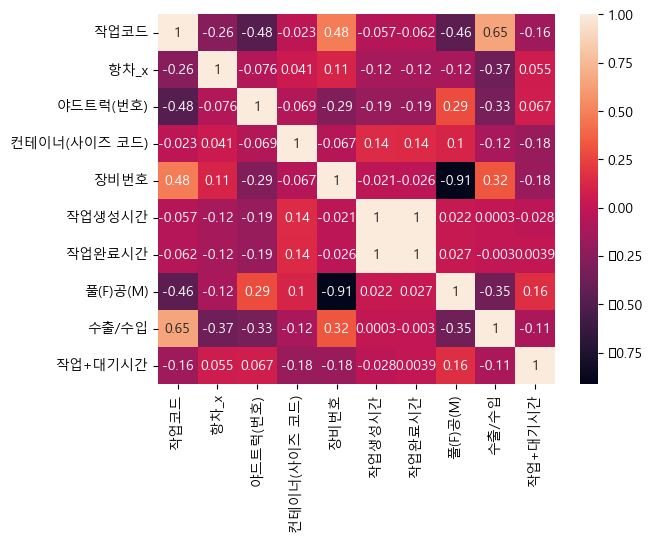

In [4]:
# data, quay merge
common_df_truck_out = common_df[common_df['야드트럭(번호)'] != 1]
print(common_df_truck_out.shape)
common_df_truck_in = common_df[common_df['야드트럭(번호)'] == 1]
print(common_df_truck_in.shape)
correlation_matrix = common_df_truck_out[['작업코드','항차_x','야드트럭(번호)','컨테이너(사이즈 코드)','장비번호', '작업생성시간','작업완료시간', '풀(F)공(M)', '수출/수입','작업+대기시간']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

정규분포 그래프

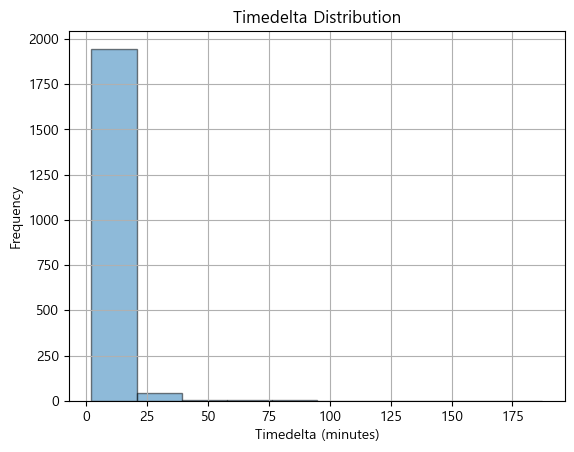

In [5]:
data = common_df_truck_out['작업+대기시간']
# print(data)
# Timedelta 값을 숫자 값으로 변환
data = data.dt.total_seconds() / 60  # timedelta 값을 분으로 변환

# 정규분포 그래프 그리기
plt.hist(data, bins=10, edgecolor='black', alpha=0.5)
plt.xlabel('Timedelta (minutes)')
plt.ylabel('Frequency')
plt.title('Timedelta Distribution')
plt.grid(True)
plt.show()

모델 학습 전 추가 전처리

In [6]:
common_df2 = common_df
common_df2['풀(F)공(M)'] = common_df2['풀(F)공(M)'].astype('int64')
common_df2 = common_df2.dropna(subset=['작업+대기시간'])

# 작업생성시간을 Unix timestamp로 변환
common_df2['작업생성시간'] = common_df2['작업생성시간'].astype('int64') // 10**9
common_df2['작업+대기시간'] = common_df2['작업+대기시간'].dt.total_seconds() /60.0

common_df2['풀(F)공(M)'] = common_df2['풀(F)공(M)'].astype('int64')
common_df2 = common_df2.dropna(subset=['작업+대기시간'])
common_df_complete = common_df2

C:\Users\SW\AppData\Local\Temp\ipykernel_19052\347278900.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_df2['작업생성시간'] = common_df2['작업생성시간'].astype('int64') // 10**9
C:\Users\SW\AppData\Local\Temp\ipykernel_19052\347278900.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_df2['작업+대기시간'] = common_df2['작업+대기시간'].dt.total_seconds() /60.0
C:\Users\SW\AppData\Local\Temp\ipykernel_19052\347278900.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

CNN 모델 학습

Epoch 1/10
153/153 [==============================] - 1s 2ms/step - loss: 108.5887 - val_loss: 112.5301
Epoch 2/10
153/153 [==============================] - 0s 1ms/step - loss: 86.0761 - val_loss: 106.1698
Epoch 3/10
153/153 [==============================] - 0s 1ms/step - loss: 80.7739 - val_loss: 101.4781
Epoch 4/10
153/153 [==============================] - 0s 1ms/step - loss: 76.9263 - val_loss: 97.5860
Epoch 5/10
153/153 [==============================] - 0s 1ms/step - loss: 74.1396 - val_loss: 95.4539
Epoch 6/10
153/153 [==============================] - 0s 1ms/step - loss: 72.3908 - val_loss: 93.7662
Epoch 7/10
153/153 [==============================] - 0s 1ms/step - loss: 71.4773 - val_loss: 92.9850
Epoch 8/10
153/153 [==============================] - 0s 1ms/step - loss: 70.9839 - val_loss: 92.2012
Epoch 9/10
153/153 [==============================] - 0s 1ms/step - loss: 70.5910 - val_loss: 91.8280
Epoch 10/10
39/39 [==============================] - 0s 761us/step
실제값: 5.0 예측

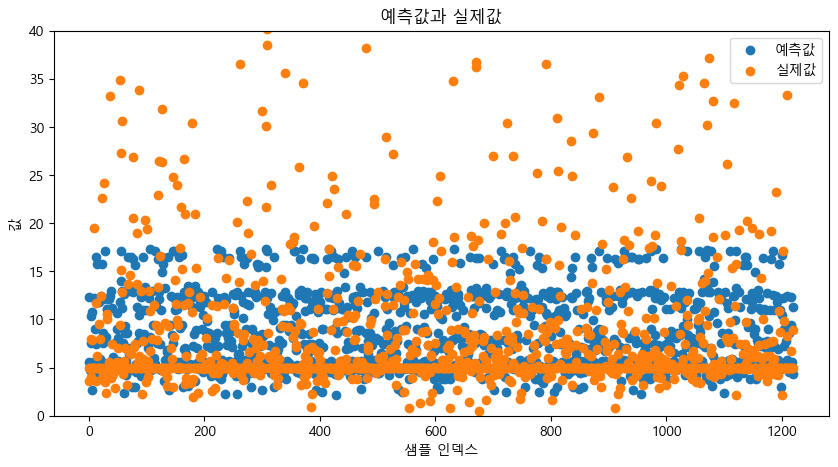

In [7]:
# common_df_complete = common_df_complete[-700:]
X = common_df_complete[['작업코드','항차_x','야드트럭(번호)','컨테이너(사이즈 코드)','장비번호', '풀(F)공(M)', '수출/수입']]
y = common_df_complete['작업+대기시간']

# 데이터 전처리
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# CNN 모델 구성
model = Sequential()
# 합성곱(Conv1D) 레이어
model.add(Conv1D(64, 3, activation='relu', input_shape=(X_train.shape[1], 1)))
# 풀링(MaxPooling1D) 레이어
model.add(MaxPooling1D(2))
model.add(Flatten())
# 완전연결(Dense) 레이어 활성화 함수(relu)
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
# 모델 컴파일
model.compile(loss='mean_squared_error', optimizer='adam')
# 모델 훈련
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
# 모델 예측
predictions = model.predict(X_test)

# 결과 출력
for i in range(len(predictions)):
    print('실제값:', y_test.values[i], '예측값:', predictions[i][0])

# 그래프 설정
# 모델 예측
predictions = model.predict(X_test)

# 그래프 설정
plt.figure(figsize=(10, 5))
plt.scatter(range(len(predictions)), predictions, label='예측값')
plt.scatter(range(len(y_test)), y_test, label='실제값')
plt.xlabel('샘플 인덱스')
plt.ylabel('값')
plt.title('예측값과 실제값')
plt.ylim(0, 40)  # y축 범위 설정
plt.legend()
plt.show()

평가 지표

In [8]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

# 평가 지표 출력
print('평균 절대 오차 (MAE):', mae)
print('평균 제곱근 오차 (RMSE):', rmse)
print('평균 제곱 오차 (MSE):', mse)
print('결정 계수 (R^2):', r2)

평균 절대 오차 (MAE): 4.564828338526716
평균 제곱근 오차 (RMSE): 9.56426598013172
평균 제곱 오차 (MSE): 91.47518373870498
결정 계수 (R^2): 0.16173937013974315
